In [1]:
import os
import sys
import pathlib
import getpass

## Environment Setup

This section checks the runtime environment to see if the notebook is running inside a Google Colab instance. If it is, then it installs the `makassar-ml` package from the GitHub repo and mounts the user's Google Drive folder to the workspace.

In [2]:
# Detect if running in Google Colab environment.
# If so, then clone/install package from GitHub.
# Otherwise, use locally.
try:
    import google.colab
    IN_COLAB = True
    print('IN COLAB')

except:
    IN_COLAB = False
    print('NOT IN COLAB')

IN COLAB


In [3]:
# Install package from GitHub if in Google Drive.
if IN_COLAB:
    config_path = pathlib.Path('./config.json')
    if config_path.exists():
        import json
        with open(config_path, 'r') as f:
            j = json.load(f)
        os.environ['GITHUB_TOKEN'] = j['GITHUB_TOKEN']

    else:

        # Request GitHub access token.
        if os.getenv('GITHUB_TOKEN',None) is None:
            os.environ['GITHUB_TOKEN'] = getpass.getpass('GitHub Token: ')
        else:
            print('Using cached GitHub Token')
        
        import json
        with open(config_path, 'w+') as f:
            json.dump(
                {'GITHUB_TOKEN': os.environ['GITHUB_TOKEN']}, 

                
                f,
            )

    # Clone or update repo.
    repo = "makassar-ml"
    repo_url = f"https://{os.environ['GITHUB_TOKEN']}@github.com/news-vt/{repo}.git"
    repo_path = f"/content/{repo}"
    repo_branch = "develop"
    ![ -d $repo_path ] && git -C $repo_path pull || git clone --branch $repo_branch $repo_url
    # !git clone --branch $repo_branch $repo_url

    # Install repo to ensure dependencies are resolved.
    !pip install --upgrade $repo_path

    # Add package location to path.
    sys.path.insert(0, repo_path)

Already up to date.
Processing ./makassar-ml
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for makassar-ml: filename=makassar_ml-0.1.0-py3-none-any.whl size=10827 sha256=eaf2f17760d1163d57c8d2597dfc304617596b91fc399d5740f52e60f2363626
  Stored in directory: /root/.cache/pip/wheels/74/23/8c/5a926f2dd1be9f44af1bf2ca82c4066c5a37ead034a2c97554
Successfully built makassar-ml
  Attempting uninstall: makassar-ml
    Found existing installation: makassar-ml 0.1.0
    Uninstalling makassar-ml-0.1.0:
      Succes

In [4]:
# Install future annotations for <3.7
if sys.version_info < (3,7):
    !pip install future-annotations

In [5]:
# Model save location in Google Drive.
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# Set dataset and model checkpoint root directories.
if IN_COLAB:
    dataset_root = pathlib.Path(f'/content/gdrive/My Drive/ml/datasets')
    checkpoint_root = pathlib.Path(f'/content/gdrive/My Drive/ml/makassar-ml/checkpoints')
else:
    dataset_root = pathlib.Path('../datasets/')
    checkpoint_root = pathlib.Path('../model_checkpoints/')

## Model Definitions

In [7]:
from __future__ import annotations
import makassar_ml as ml
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt

In [8]:
class BeijingPM25ForecastTransformer(pl.LightningModule):
    def __init__(self, *args, learning_rate: float = 1e-5, **kwargs):
        super().__init__()
        self.learning_rate = learning_rate
        self.criterion = torch.nn.MSELoss(reduction='mean')

        # Create the transformer model.
        self.model = ml.nn.TimeseriesTransformer(*args, **kwargs)

        # Copy batch-first member if the underlying model has one.
        self.batch_first = getattr(self.model, 'batch_first', False)

        # Save parameters for checkpoint.
        self.save_hyperparameters()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        return self.model(*args, **kwargs)

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.model.parameters(), 
            # lr=1e-3,
            lr=self.learning_rate, 
            betas=[0.9, 0.98], 
            eps=1e-9,
            )

    def compute_loss(self, y_hat, y):
        return self.criterion(y_hat, y)

    def create_seed(self, batch_size: int, feat_size: int):
        """Helper to create seed tensor for decoder input."""
        if self.batch_first:
            shape = (batch_size,1,feat_size)
        else:
            shape = (1,batch_size,feat_size)
        return torch.zeros(shape).to(device=self.device)

    def step(self, batch: torch.Tensor, batch_idx: int, stage: str) -> float:
        """Generic step function used for train/validation/test loops.

        Args:
            batch (torch.Tensor): Tensor of batched records.
            batch_idx (int): Index of batch relative to entire dataset.
            stage (str): Stage key for logging purposes (one of ['train','val','test']).

        Returns:
            float: Prediction loss.
        """
        history_x, history_y, horizon_x, horizon_y = batch

        # Create decoder input sequence.
        # This should start with the last element of the encoder sequence
        # and end with the second-to-last element of the target sequence.
        if self.model.batch_first:
            batch_dim, seq_dim, feat_dim = horizon_y.shape
            seed = self.create_seed(batch_dim, feat_dim)
            tgt = torch.cat(
                # (history_x[:,[-1],:], horizon_x[:,:-1,:]),
                (seed, horizon_y[:,:-1,:]),
                dim=1,
                )
        else:
            seq_dim, batch_dim, feat_dim = horizon_y.shape
            seed = self.create_seed(batch_dim, feat_dim)
            tgt = torch.cat(
                # (history_x[[-1],:,:], horizon_x[:-1,:,:]),
                (seed, horizon_y[:-1,:,:]),
                dim=0,
                )
        
        # Create target attention mask to prevent lookahead cheating.
        if self.model.batch_first:
            tgt_length = tgt.size(1)
        else:
            tgt_length = tgt.size(0)
        tgt_mask = ml.nn.utils.create_attn_mask(length=tgt_length).to(device=self.device)

        # Pass source and target sequences into the transformer.
        y_hat = self(history_x, tgt, tgt_mask)

        # Compute loss.
        loss = self.compute_loss(y_hat, horizon_y)
        # loss = self.compute_loss(y_hat, horizon_x)

        # print(f"{batch_idx=} {history_x=} {tgt=} {tgt_mask=} {y_hat=} {horizon_y=} {loss=}")

        self.log(f'{stage}_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch: torch.Tensor, batch_idx: int) -> float:
        return self.step(batch, batch_idx, stage='train')

    def validation_step(self, batch: torch.Tensor, batch_idx: int) -> float:
        return self.step(batch, batch_idx, stage='val')

    def test_step(self, batch: torch.Tensor, batch_idx: int) -> float:
        return self.step(batch, batch_idx, stage='test')
        # #
        # #
        # history_x, history_y, horizon_x, horizon_y = batch

## Training

In [9]:
# %reload_ext tensorboard
# %tensorboard --logdir ./lightning_logs

In [10]:
# Define parameters for the dataset.
# feature_cols = [0,1,2,3]
feature_cols = [6]
# target_cols = [-3, -2]
target_cols = [6]
history = 24
horizon = 8
# split = 0.15
# split = 0.75
split = 0.90
batch_size = 64
# batch_size = 1

# Create the dataset.
dm = ml.datasets.BeijingPM25LightningDataModule(
    root=dataset_root,
    feature_cols=feature_cols,
    target_cols=target_cols,
    history=history,
    horizon=horizon,
    split=split,
    batch_size=batch_size,
    normalize='standard',
)

n_input_features: int = len(feature_cols)
n_output_features: int = len(target_cols)
# n_output_features: int = len(feature_cols)
d_time_embed = 6 * n_input_features # Time embedding dimension should be a multiple of the input feature dimension.
d_model: int = 512
dropout: float = 0.2
n_encoder_layers: int = 4
n_decoder_layers: int = 4

### Learning Rate Search

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Restoring states from the checkpoint path at /content/lr_find_temp_model_b5b0ae6c-8652-4db5-b2bb-751473df358f.ckpt


learning rate finder results: {'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033

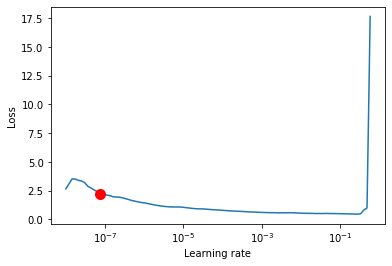

In [11]:
LRSEARCH = True
# learning_rate = 1e-8 # Default learning rate.
# learning_rate = 1e-3 # Default learning rate.

if LRSEARCH:
    model = BeijingPM25ForecastTransformer(
        n_input_features=n_input_features,
        n_output_features=n_output_features,
        d_time_embed=d_time_embed,
        d_model=d_model,
        dropout=dropout,
        batch_first=True,
        n_encoder_layers=n_encoder_layers,
        n_decoder_layers=n_decoder_layers,
        )

    # Create trainer.
    kwargs = {}
    if torch.cuda.is_available(): kwargs['gpus'] = -1 # Use all available GPUs.
    kwargs['auto_lr_find'] = True
    trainer = pl.Trainer(**kwargs)

    # Run learning rate finder
    lr_finder = trainer.tuner.lr_find(model, datamodule=dm)

    # Results can be found in
    print(f"learning rate finder results: {lr_finder.results}")

    # Plot with
    fig = lr_finder.plot(suggest=True)
    fig.show()

    # Pick point based on plot, or get suggestion
    learning_rate = lr_finder.suggestion()
    print(f"learning rate suggestion: {learning_rate}")

### Fitting the Module

In [12]:
TRAIN = True
ckpt_filename_base = f"beijing-pm25-transformer-feat={feature_cols}-target={target_cols}"
ckpt_file_path = checkpoint_root/"beijing-pm25-transformer-feat=[6]-target=[6]-epoch=00-train_loss=35.84-val_loss=101.68.ckpt"

if TRAIN:
    model = BeijingPM25ForecastTransformer(
        n_input_features=n_input_features,
        n_output_features=n_output_features,
        d_time_embed=d_time_embed,
        d_model=d_model,
        dropout=dropout,
        batch_first=True,
        n_encoder_layers=n_encoder_layers,
        n_decoder_layers=n_decoder_layers,
        learning_rate=learning_rate,
        )

    kwargs = {}
    kwargs['max_epochs'] = 10
    if torch.cuda.is_available(): kwargs['gpus'] = -1 # Use all available GPUs.
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor="val_loss",
        mode='min',
        dirpath=checkpoint_root,
        filename=ckpt_filename_base+'-{epoch:02d}-{train_loss:.2f}-{val_loss:.2f}',
        save_top_k=1,
    )
    kwargs['callbacks'] = [checkpoint_callback]
    trainer = pl.Trainer(**kwargs)

    # Train or load the model.
    trainer.fit(model, dm)

    # Print best model path.
    ckpt_file_path = checkpoint_callback.best_model_path
    print(f"Best model ckpt: {checkpoint_callback.best_model_path}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                  | Params
----------------------------------------------------
0 | criterion | MSELoss               | 0     
1 | model     | TimeseriesTransformer | 29.4 M
----------------------------------------------------
29.4 M    Trainable params
0         Non-trainable params
29.4 M    Total params
117.723   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/gdri

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Best model ckpt: /content/gdrive/My Drive/ml/makassar-ml/checkpoints/beijing-pm25-transformer-feat=[6]-target=[6]-epoch=09-train_loss=0.77-val_loss=3.53.ckpt


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


## Testing

Here we try to forecast some features and plot them to see how well model does.

In [13]:
# trainer.test(model, dm)

## Evaluation

In [14]:
# Create new model from checkpoint for inference.
model = BeijingPM25ForecastTransformer.load_from_checkpoint(ckpt_file_path)

In [15]:
# def old_evaluate(model: torch.nn.Module, data: torch.Tensor, horizon: int) -> torch.Tensor:

#     # Prepare output sequence tensor.
#     if model.batch_first:
#         dim_batch, dim_seq, dim_feat = data.shape
#     else:
#         dim_seq, dim_batch, dim_feat = data.shape
#     out_seq = torch.empty((dim_batch, 0, dim_feat)).to(model.device)
#     data = data.to(model.device)

#     model.eval()
#     with torch.no_grad():
#         while True:
#             # Create decoder input sequence.
#             # This should start with the last element of the encoder sequence
#             # and end with the second-to-last element of the target sequence.
#             if model.batch_first: # Batch dimension first.
#                 tgt = data[:,[-1],:]
#             else: # Sequence dimension first.
#                 tgt = data[[-1],:,:]

#             # Pass source and target sequences into the transformer.
#             y_hat = model(data, tgt)
#             # print(y_hat.shape)
#             print('out_seq.shape',out_seq.shape)

#             # Add predicted value to output sequence.
#             # out_seq.append(y_hat)
#             if model.batch_first:
#                 out_seq = torch.cat(
#                     (out_seq, y_hat),
#                     dim=1,
#                 )
#             else:
#                 out_seq = torch.cat(
#                     (out_seq, y_hat),
#                     dim=0,
#                 )

#             # Shift the input and target.
#             if model.batch_first: # Batch dimension first.
#                 data = torch.cat(
#                     (data[:,1:,:], y_hat),
#                     dim=1,
#                     )
#             else:
#                 data = torch.cat(
#                     (data[1:,:,:], y_hat),
#                     dim=0,
#                     )

#             # Check if sequence length has been reached.
#             seq_len = out_seq.size(1 if model.batch_first else 0)
#             if seq_len >= horizon:
#                 break

#     return out_seq

In [16]:
def evaluate(model: torch.nn.Module, data: torch.Tensor, horizon: int) -> torch.Tensor:

    # Prepare output sequence tensor.
    if model.batch_first:
        dim_batch, dim_seq, dim_feat = data.shape
    else:
        dim_seq, dim_batch, dim_feat = data.shape
    out_seq = torch.empty((dim_batch, 0, n_output_features)).to(model.device)
    data = data.to(model.device)

    # Create decoder input sequence.
    # This should start with the last element of the encoder sequence
    # and end with the second-to-last element of the target sequence.
    tgt = model.create_seed(dim_batch, n_output_features)

    print(f'horizon={horizon}')
    print('dims:',dim_batch, dim_seq, dim_feat)
    print(f'out_seq.shape={out_seq.shape} out_seq={out_seq}')
    print(f'tgt.shape={tgt.shape} tgt={tgt}')

    # Generate output sequence using initial target seed.
    model.eval()
    with torch.no_grad():
        while True:

            # Pass source and target sequences into the transformer.
            y_hat = model(data, tgt)
            print(f'tgt.shape={tgt.shape} tgt={tgt} | y_hat.shape={y_hat.shape} y_hat={y_hat}')

            # Add predicted value to output sequence.
            out_seq = torch.cat(
                (out_seq, y_hat),
                dim=(1 if model.batch_first else 0),
            )

            # Set prediction as next target point.
            tgt = y_hat

            # Check if sequence length has been reached.
            seq_len = out_seq.size(1 if model.batch_first else 0)
            if seq_len >= horizon:
                break

    return out_seq

In [17]:
dm.setup('test')
history_x, history_y, horizon_x, horizon_y = dm.dataset_test_wrap[0] # Get first test window.
history_x = history_x.unsqueeze(0) # Add batch dimension.
history_y = history_y.unsqueeze(0)
horizon_x = horizon_x.unsqueeze(0)
horizon_y = horizon_y.unsqueeze(0)

out_seq = evaluate(
    model,
    history_x,
    horizon,
    )
print(f'out_seq={out_seq}')
print(f'n_output_features={n_output_features}')

horizon=8
dims: 1 24 1
out_seq.shape=torch.Size([1, 0, 1]) out_seq=tensor([], size=(1, 0, 1))
tgt.shape=torch.Size([1, 1, 1]) tgt=tensor([[[0.]]])
tgt.shape=torch.Size([1, 1, 1]) tgt=tensor([[[0.]]]) | y_hat.shape=torch.Size([1, 1, 1]) y_hat=tensor([[[-0.6643]]])
tgt.shape=torch.Size([1, 1, 1]) tgt=tensor([[[-0.6643]]]) | y_hat.shape=torch.Size([1, 1, 1]) y_hat=tensor([[[-0.6358]]])
tgt.shape=torch.Size([1, 1, 1]) tgt=tensor([[[-0.6358]]]) | y_hat.shape=torch.Size([1, 1, 1]) y_hat=tensor([[[-0.6371]]])
tgt.shape=torch.Size([1, 1, 1]) tgt=tensor([[[-0.6371]]]) | y_hat.shape=torch.Size([1, 1, 1]) y_hat=tensor([[[-0.6370]]])
tgt.shape=torch.Size([1, 1, 1]) tgt=tensor([[[-0.6370]]]) | y_hat.shape=torch.Size([1, 1, 1]) y_hat=tensor([[[-0.6370]]])
tgt.shape=torch.Size([1, 1, 1]) tgt=tensor([[[-0.6370]]]) | y_hat.shape=torch.Size([1, 1, 1]) y_hat=tensor([[[-0.6370]]])
tgt.shape=torch.Size([1, 1, 1]) tgt=tensor([[[-0.6370]]]) | y_hat.shape=torch.Size([1, 1, 1]) y_hat=tensor([[[-0.6370]]])
tgt.

No handles with labels found to put in legend.


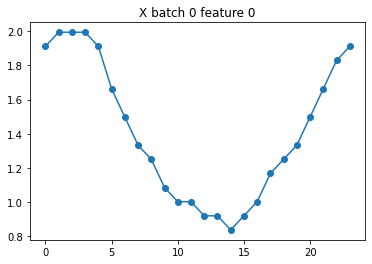

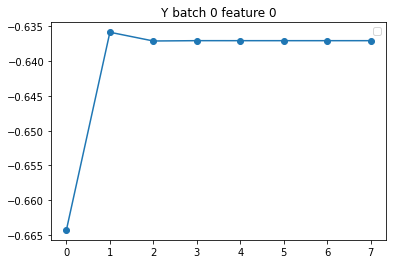

In [18]:
# Plot the evaluation predictions
for idx,batch in enumerate(out_seq):
    plt.figure()
    for feat_idx in range(history_x[idx].size(-1)):
        x = torch.arange(0, history_x.size(1))

        plt.subplot(history_x[idx].size(-1), 1, feat_idx+1)
        plt.plot(history_x[idx,:,feat_idx].cpu(), 'o-')
        plt.gca().set_title(f"X batch {idx} feature {feat_idx}")
    # plt.legend()

    plt.figure()
    for feat_idx in range(batch.size(-1)):
        x = torch.arange(history_x.size(1), history_x.size(1)+batch.size(0))

        plt.subplot(batch.size(-1), 1, feat_idx+1)
        plt.plot(batch[:,feat_idx].cpu(), 'o-')
        plt.gca().set_title(f"Y batch {idx} feature {feat_idx}")
    plt.legend()